In [24]:
# Loading required Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot

# Load data
excel_file_path = "/Users/yujuechen/Downloads/Digital tools for finance/data.xlsx"
data = pd.read_excel(excel_file_path)

# Convert quarters to a Date format
data['Time']=pd.to_datetime(data['Time'])
data['Year']=data['Time'].dt.year
data['Quarter']=data['Time'].dt.quarter
data['Quarter'] = 'Q' + data['Quarter'].astype(str)

# Convert percentage columns
percentage_columns = ['core_inflation', 'headline_inflation', 'government_bond_yield_sixm',
                       'government_bond_yield_fivey', 'government_bond_yield_teny']
data[percentage_columns] *= 100


# Display summary statistics
c1 = ["House_price", "Gold_price", "Fixed_deposit_rate", "Shanghai_stock_index", 
        "government_bond_yield_sixm", "government_bond_yield_fivey", "government_bond_yield_teny"]
summary_data = data.describe().loc[['mean', 'std', 'min', 'max'], c1].transpose()
print(summary_data)


                                     mean          std        min         max
House_price                  15028.977273  5971.001562  6399.0000  23006.0000
Gold_price                     291.587500    47.018941   222.9900    402.6400
Fixed_deposit_rate               3.653409     0.718962     3.0000      5.0000
Shanghai_stock_index          2812.791005   517.081971  1979.2060   4277.2219
government_bond_yield_sixm       2.678539     0.629197     1.4136      4.1741
government_bond_yield_fivey      3.139277     0.498754     2.3372      4.4583
government_bond_yield_teny       3.421255     0.457127     2.5899      4.5518


In [14]:
# Calculate percentage changes
data['House_Change'] = (data['House_price'] - data['House_price'].shift(1)) / data['House_price'].shift(1) * 100
data['Gold_Change'] = (data['Gold_price'] - data['Gold_price'].shift(1)) / data['Gold_price'].shift(1) * 100
data['Shanghai_stock_Change'] = (data['Shanghai_stock_index'] - data['Shanghai_stock_index'].shift(1)) / data['Shanghai_stock_index'].shift(1) * 100

# Replace NA with the second row as the default value
data['House_Change'].iloc[0] = data['House_Change'].iloc[1]
data['Gold_Change'].iloc[0] = data['Gold_Change'].iloc[1]
data['Shanghai_stock_Change'].iloc[0] = data['Shanghai_stock_Change'].iloc[1]

# Calculate the return rate - Asset/Inflation
data['House_proportion'] = data['House_Change'] / data['core_inflation']
data['Gold_proportion'] = data['Gold_Change'] / data['core_inflation']
data['Fixed_deposit_proportion'] = data['Fixed_deposit_rate'] / data['core_inflation']
data['Shanghai_stock_proportion'] = data['Shanghai_stock_Change'] / data['core_inflation']
data['Gover_sixm_proportion'] = data['government_bond_yield_sixm'] / data['core_inflation']
data['Gover_fivey_proportion'] = data['government_bond_yield_fivey'] / data['core_inflation']
data['Gover_teny_proportion'] = data['government_bond_yield_teny'] / data['core_inflation']

/var/folders/6h/gl5k_tj508b502ld9ctqmsgw0000gn/T/ipykernel_60125/2633367851.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6h/gl5k_tj508b502ld9ctqmsgw0000gn/T/ipykernel_60125/2633367851.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6h/gl5k_tj508b502ld9ctqmsgw0000gn/T/ipykernel_60125/2633367851.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
data['log_core_inflation'] = np.log1p(data['core_inflation'])
# Run regression house_property_price on log(core_inflation) and the other assets
lm_house_on_others = sm.OLS(data['House_Change'], sm.add_constant(data[['log_core_inflation', 'Gold_Change', 'Fixed_deposit_rate',
                                                                        'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                        'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()
print(lm_house_on_others.summary())

lm_gold_on_others = sm.OLS(data['Gold_Change'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Fixed_deposit_rate',
                                                                      'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                      'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()
print(lm_gold_on_others.summary())

lm_fixed_on_others = sm.OLS(data['Fixed_deposit_rate'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                             'Shanghai_stock_Change', 'government_bond_yield_sixm',
                                                                             'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()
print(lm_fixed_on_others.summary())

lm_stock_on_others = sm.OLS(data['Shanghai_stock_Change'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                 'Fixed_deposit_rate', 'government_bond_yield_sixm',
                                                                                 'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()
print(lm_stock_on_others.summary())

lm_sixm_on_others = sm.OLS(data['government_bond_yield_sixm'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                    'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                    'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()
print(lm_sixm_on_others.summary())

lm_fivey_on_others = sm.OLS(data['government_bond_yield_fivey'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                      'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                      'government_bond_yield_sixm', 'government_bond_yield_teny']])).fit()
print(lm_fivey_on_others.summary())

lm_teny_on_others = sm.OLS(data['government_bond_yield_teny'], sm.add_constant(data[['log_core_inflation', 'House_Change', 'Gold_Change',
                                                                                    'Fixed_deposit_rate', 'Shanghai_stock_Change',
                                                                                    'government_bond_yield_sixm', 'government_bond_yield_fivey']])).fit()
print(lm_teny_on_others.summary())

                            OLS Regression Results                            
Dep. Variable:           House_Change   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.7772
Date:                Sat, 09 Dec 2023   Prob (F-statistic):              0.610
Time:                        16:46:18   Log-Likelihood:                -139.48
No. Observations:                  44   AIC:                             295.0
Df Residuals:                      36   BIC:                             309.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [18]:
# Check correlation between different assets
col_corr = ["House_Change", "Gold_Change", "Fixed_deposit_rate", "Shanghai_stock_Change",
            "government_bond_yield_sixm", "government_bond_yield_fivey", "government_bond_yield_teny"]
data_corr = data[col_corr]
correlation_matrix = data_corr.corr()
print(correlation_matrix)

                             House_Change  Gold_Change  Fixed_deposit_rate  \
House_Change                     1.000000    -0.019876            0.018186   
Gold_Change                     -0.019876     1.000000           -0.098572   
Fixed_deposit_rate               0.018186    -0.098572            1.000000   
Shanghai_stock_Change            0.005208    -0.219298           -0.065497   
government_bond_yield_sixm      -0.223966    -0.459805            0.311045   
government_bond_yield_fivey     -0.260128    -0.321441            0.306596   
government_bond_yield_teny      -0.215020    -0.265381            0.518734   

                             Shanghai_stock_Change  \
House_Change                              0.005208   
Gold_Change                              -0.219298   
Fixed_deposit_rate                       -0.065497   
Shanghai_stock_Change                     1.000000   
government_bond_yield_sixm                0.112805   
government_bond_yield_fivey               0.081848 

In [20]:
import statsmodels.api as sm

# Model for House_Change
lm_house_on_others_new = sm.OLS(data['House_Change'], sm.add_constant(data[['log_core_inflation', 'government_bond_yield_sixm', 
                                                                             'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

# Model for Gold_Change
lm_gold_on_others_new = sm.OLS(data['Gold_Change'], sm.add_constant(data[['log_core_inflation', 'Shanghai_stock_Change', 
                                                                           'government_bond_yield_sixm', 'government_bond_yield_fivey', 
                                                                           'government_bond_yield_teny']])).fit()

# Model for Fixed_deposit_rate
lm_fixed_on_others_new = sm.OLS(data['Fixed_deposit_rate'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                 'government_bond_yield_sixm', 'government_bond_yield_fivey', 
                                                                                 'government_bond_yield_teny']])).fit()

# Model for Shanghai_stock_Change
lm_stock_on_others_new = sm.OLS(data['Shanghai_stock_Change'], sm.add_constant(data[['log_core_inflation', 'Gold_Change']])).fit()

# Model for government_bond_yield_sixm
lm_sixm_on_others_new = sm.OLS(data['government_bond_yield_sixm'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                        'Gold_Change', 'Fixed_deposit_rate', 
                                                                                        'government_bond_yield_fivey', 'government_bond_yield_teny']])).fit()

# Model for government_bond_yield_fivey
lm_fivey_on_others_new = sm.OLS(data['government_bond_yield_fivey'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                          'Gold_Change', 'Fixed_deposit_rate', 
                                                                                          'government_bond_yield_sixm', 'government_bond_yield_teny']])).fit()

# Model for government_bond_yield_teny
lm_teny_on_others_new = sm.OLS(data['government_bond_yield_teny'], sm.add_constant(data[['log_core_inflation', 'House_Change', 
                                                                                        'Gold_Change', 'Fixed_deposit_rate', 
                                                                                        'government_bond_yield_sixm', 'government_bond_yield_fivey']])).fit()

# Display summary for all models
print(lm_house_on_others_new.summary())
print(lm_gold_on_others_new.summary())
print(lm_fixed_on_others_new.summary())
print(lm_stock_on_others_new.summary())
print(lm_sixm_on_others_new.summary())
print(lm_fivey_on_others_new.summary())
print(lm_teny_on_others_new.summary())


                            OLS Regression Results                            
Dep. Variable:           House_Change   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.123
Date:                Sat, 09 Dec 2023   Prob (F-statistic):              0.360
Time:                        16:51:41   Log-Likelihood:                -140.18
No. Observations:                  44   AIC:                             290.4
Df Residuals:                      39   BIC:                             299.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [32]:
def check_assumptions(lm_model, data):
    # Check linearity
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sm.graphics.plot_fit(lm_model, 1, ax=ax)
    plt.show()

    # Check independence of residuals
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.scatterplot(x=lm_model.fittedvalues, y=lm_model.resid, ax=ax)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

    # Check homoscedasticity
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.scatterplot(x=lm_model.fittedvalues, y=lm_model.resid_pearson, ax=ax)
    plt.xlabel('Fitted Values')
    plt.ylabel('Standardized Residuals')
    plt.show()

    # Check normality of residuals
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(lm_model.resid, ax=axes[0], kde=True)
    probplot(lm_model.resid, plot=axes[1])
    plt.show()

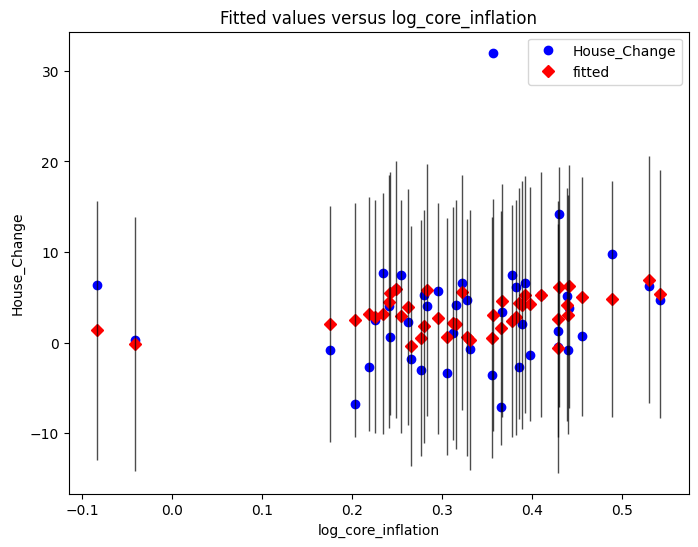

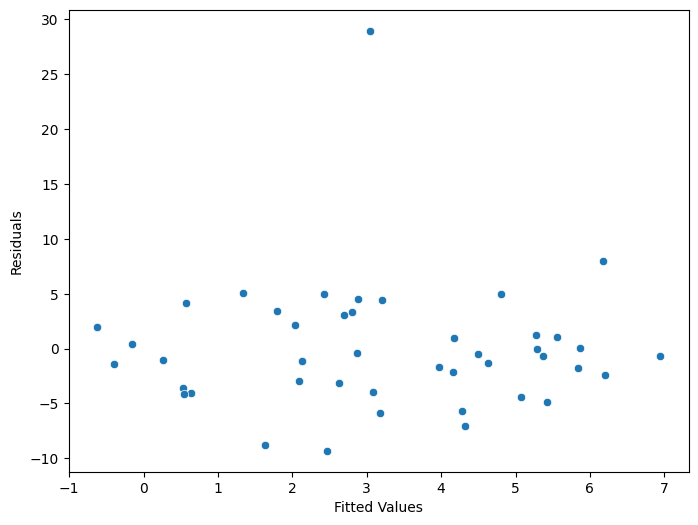

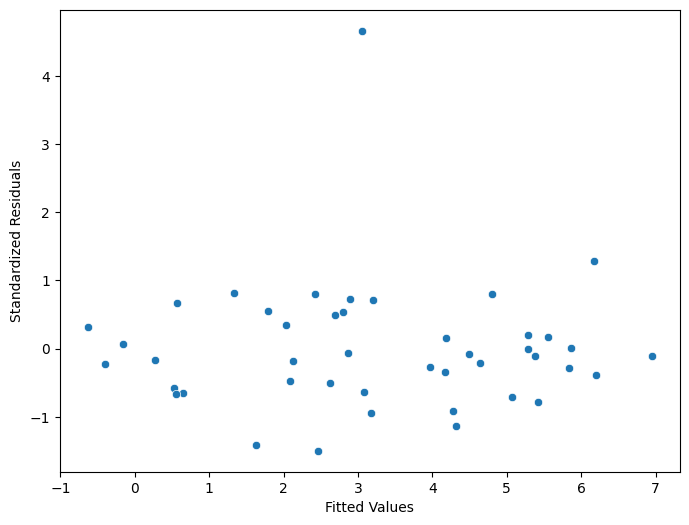

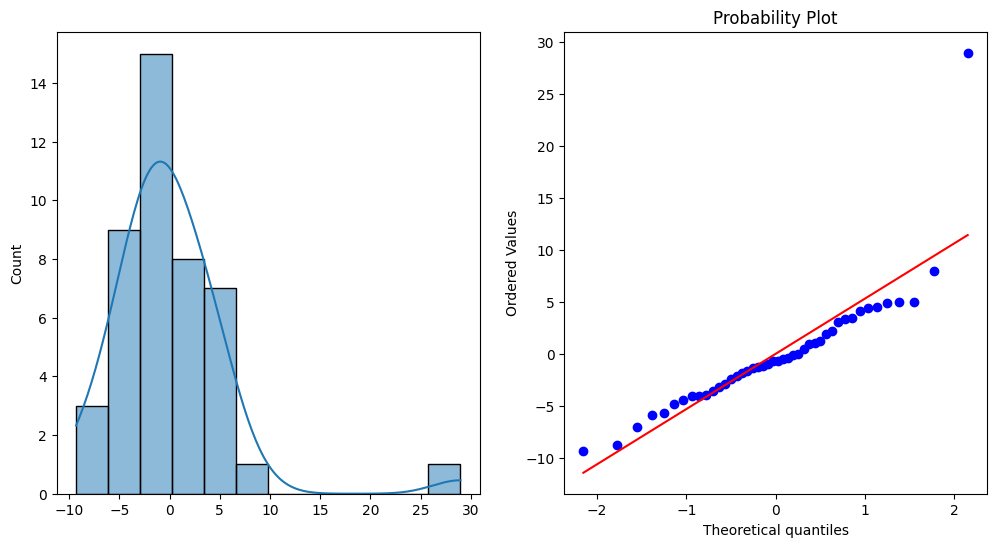

In [33]:
# Check assumptions for lm_house_on_others_new
check_assumptions(lm_house_on_others_new, data)

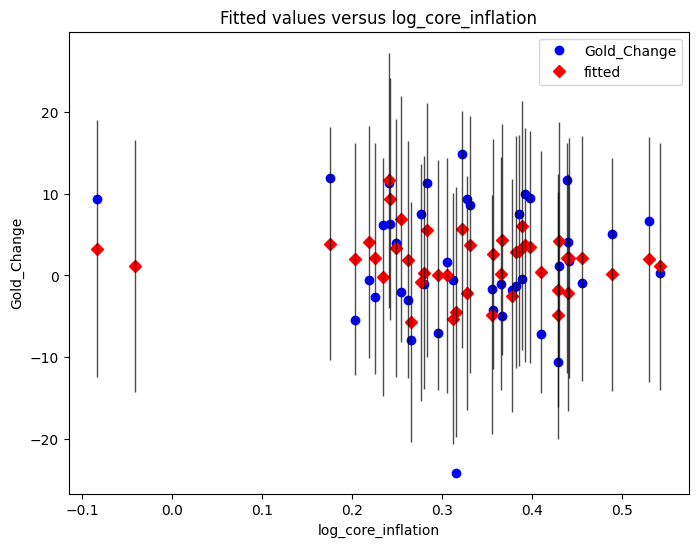

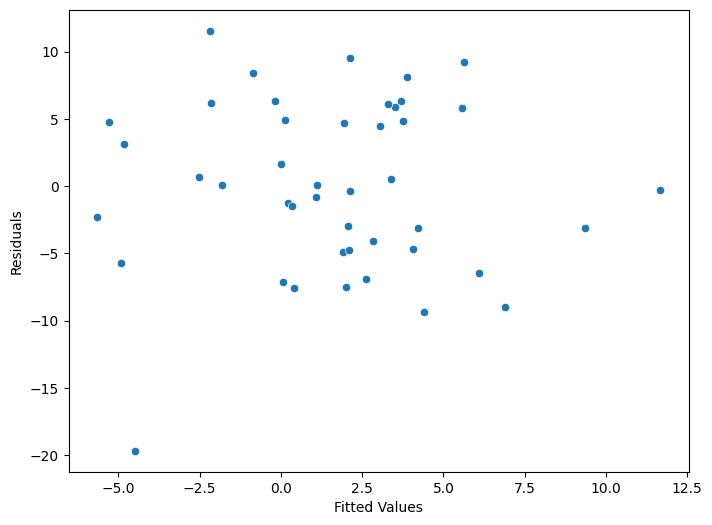

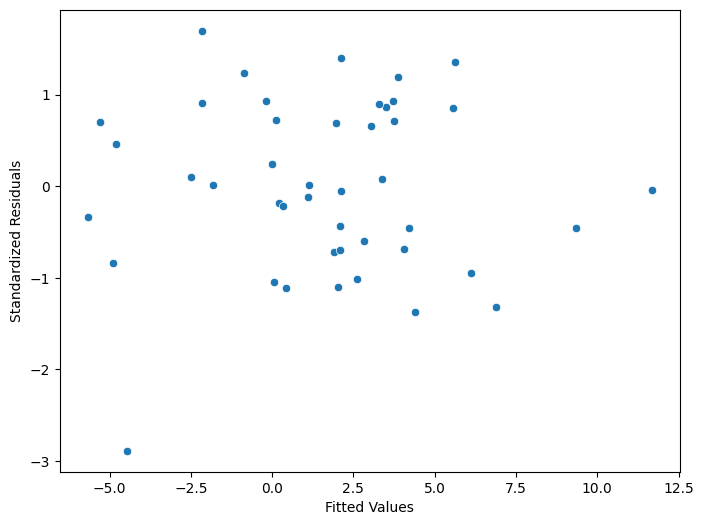

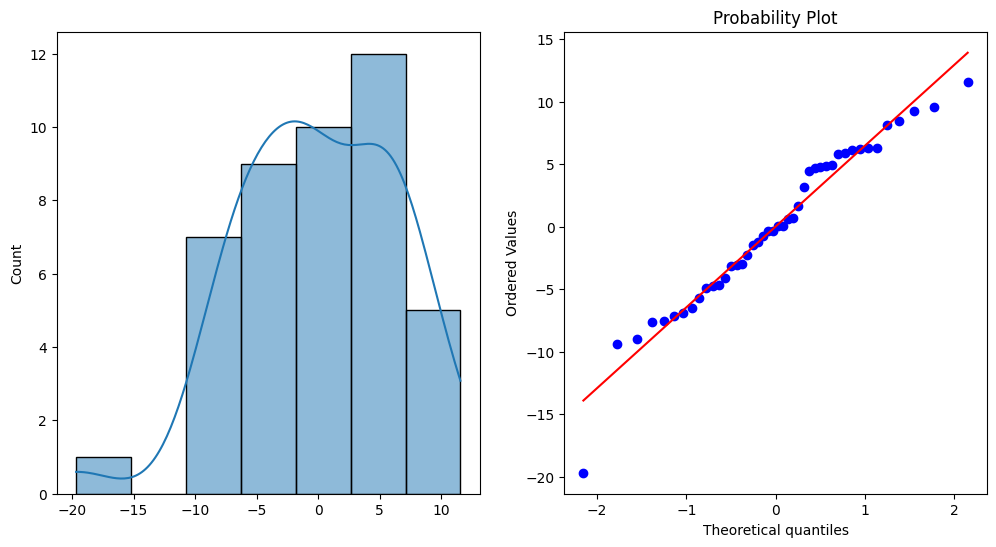

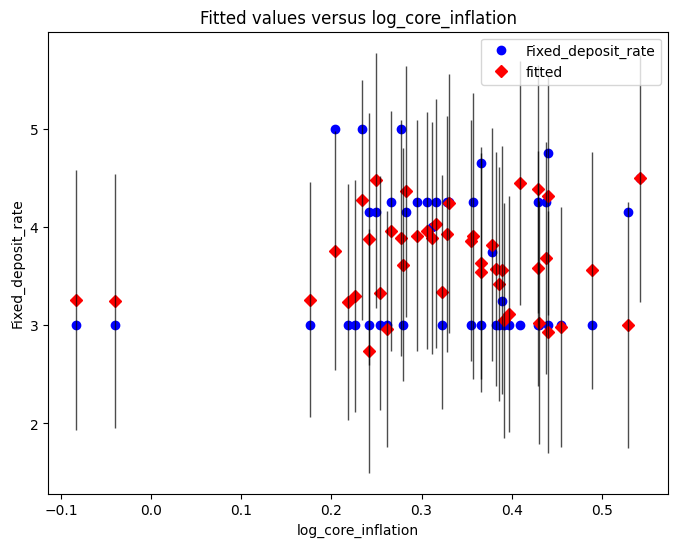

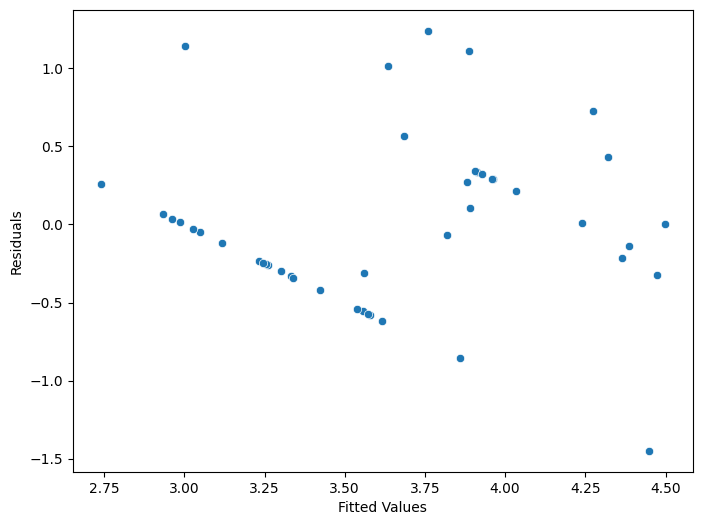

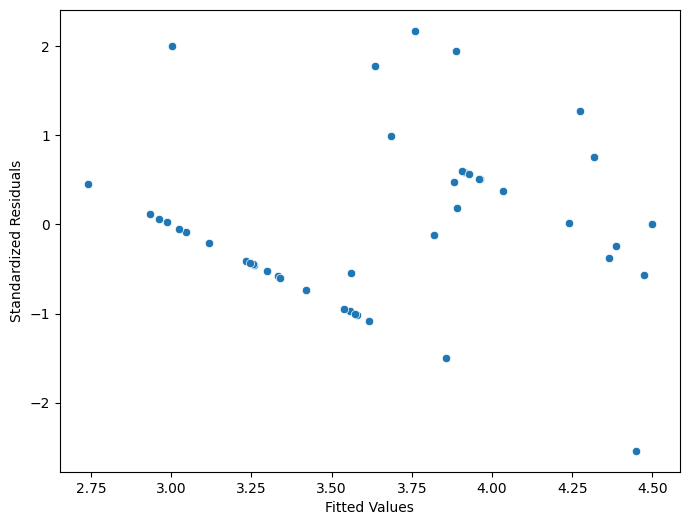

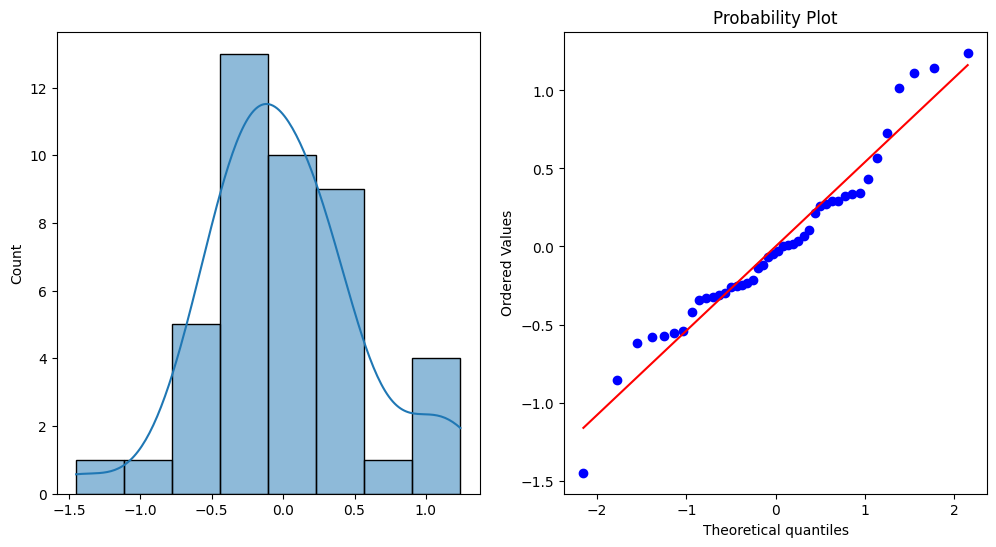

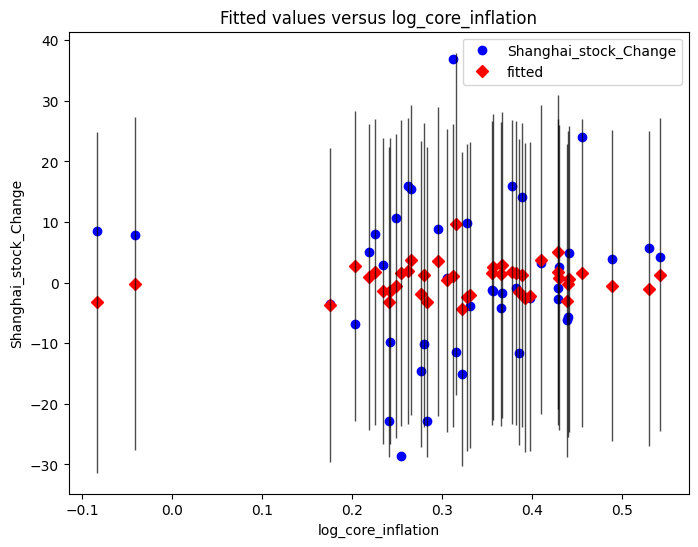

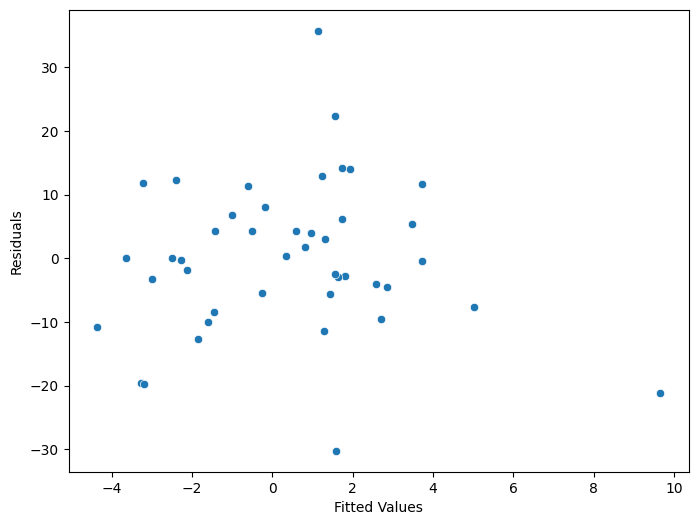

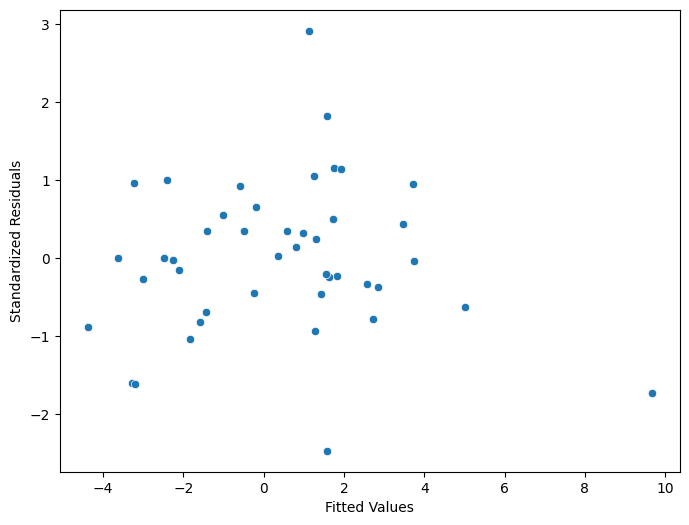

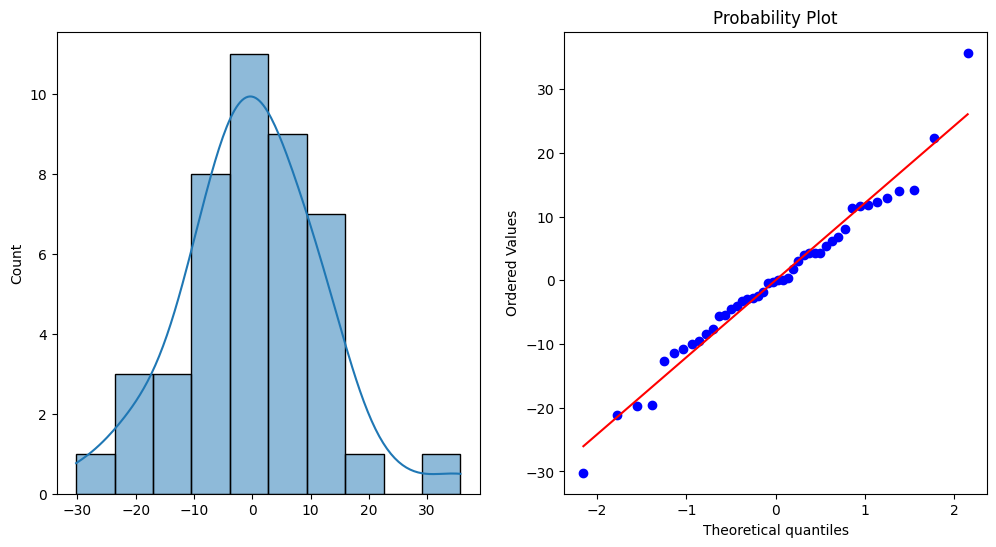

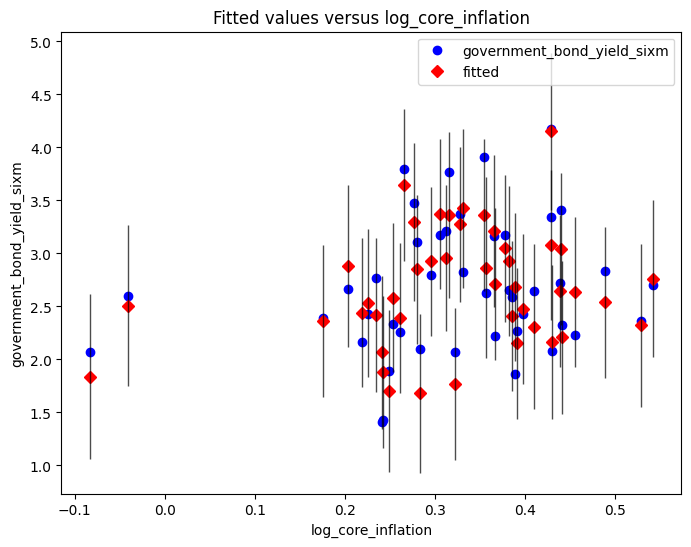

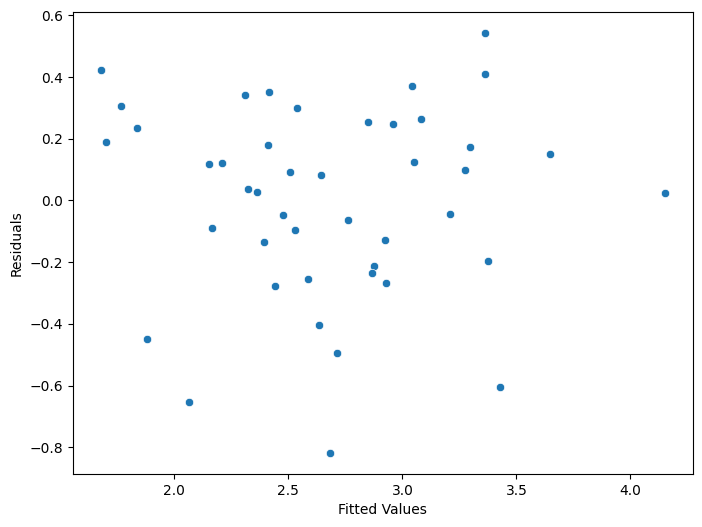

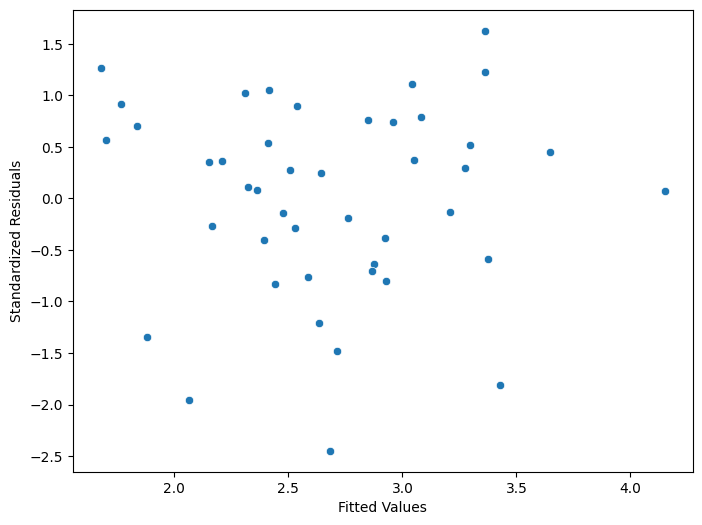

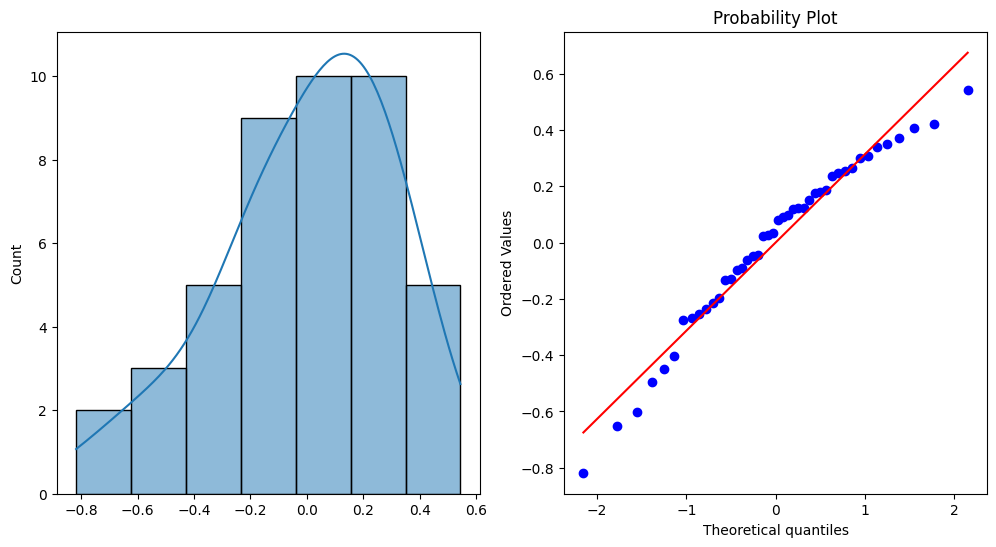

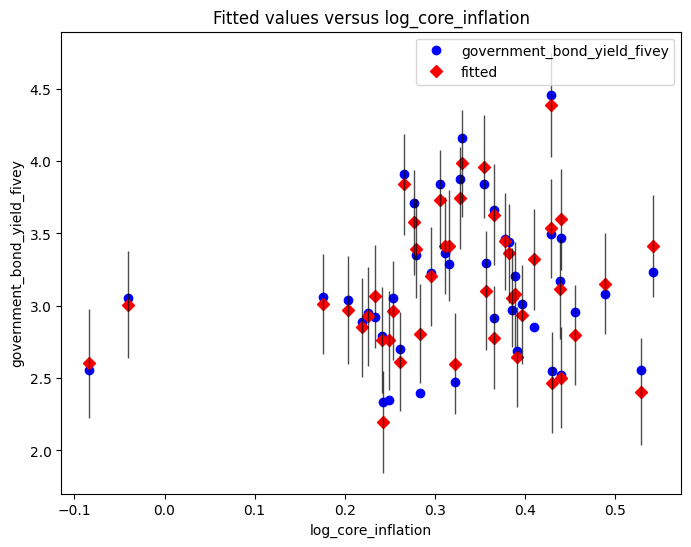

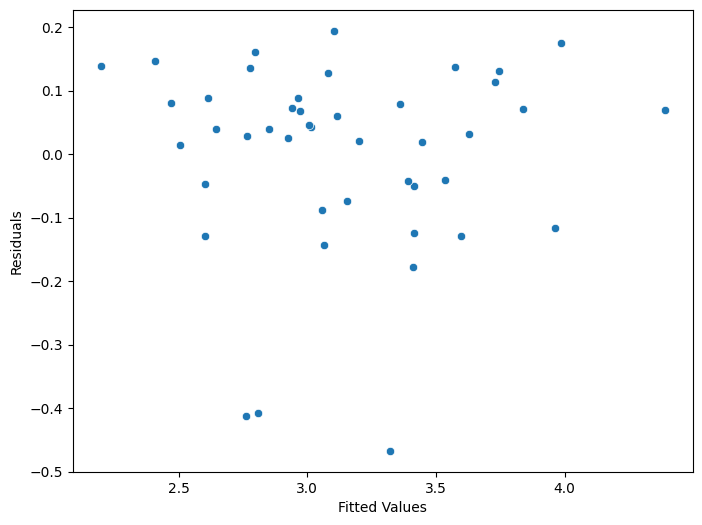

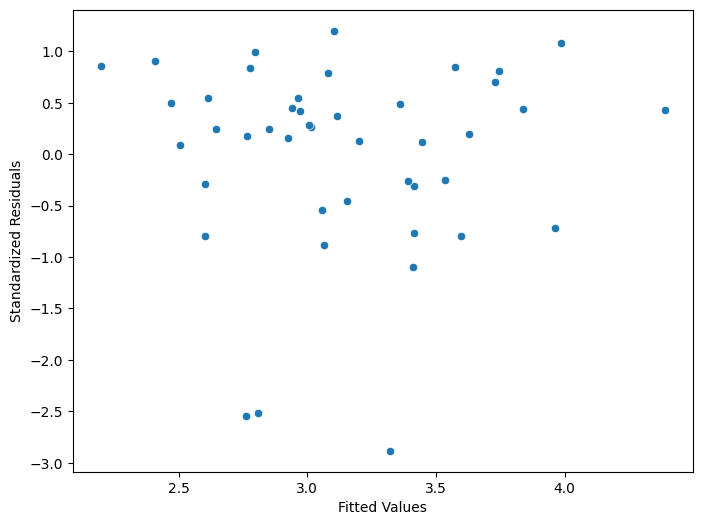

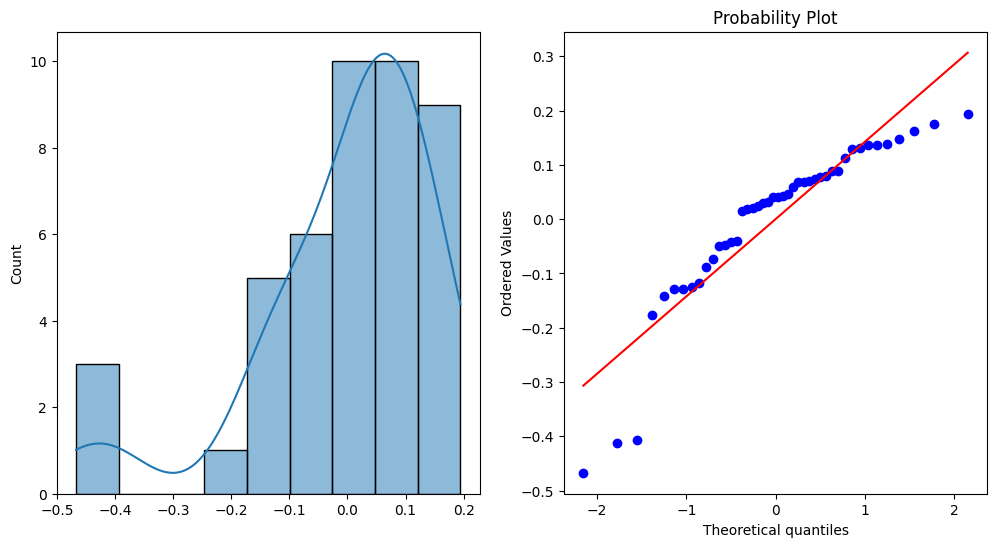

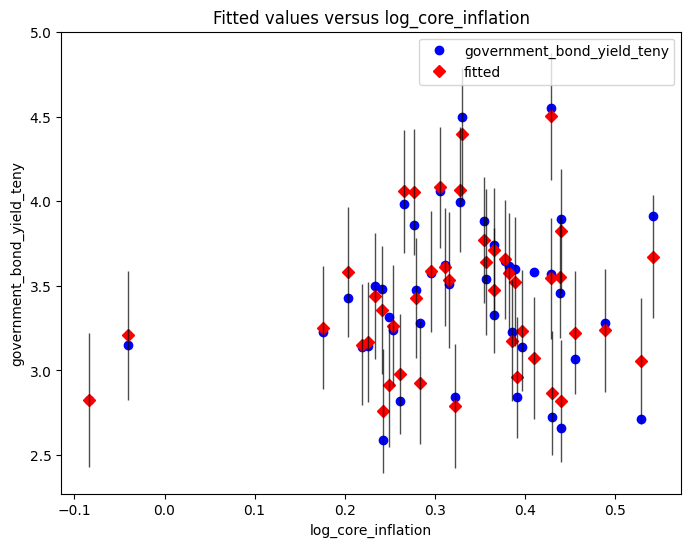

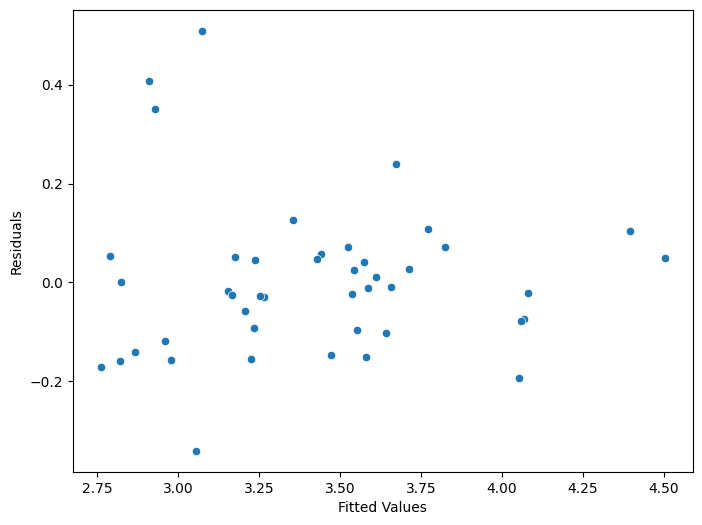

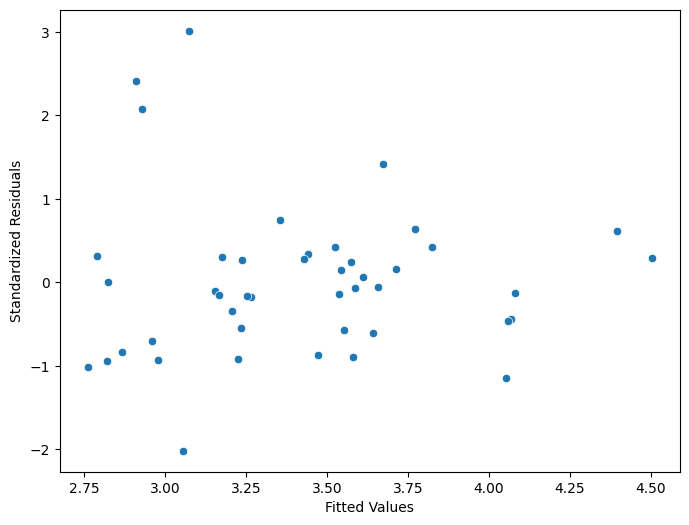

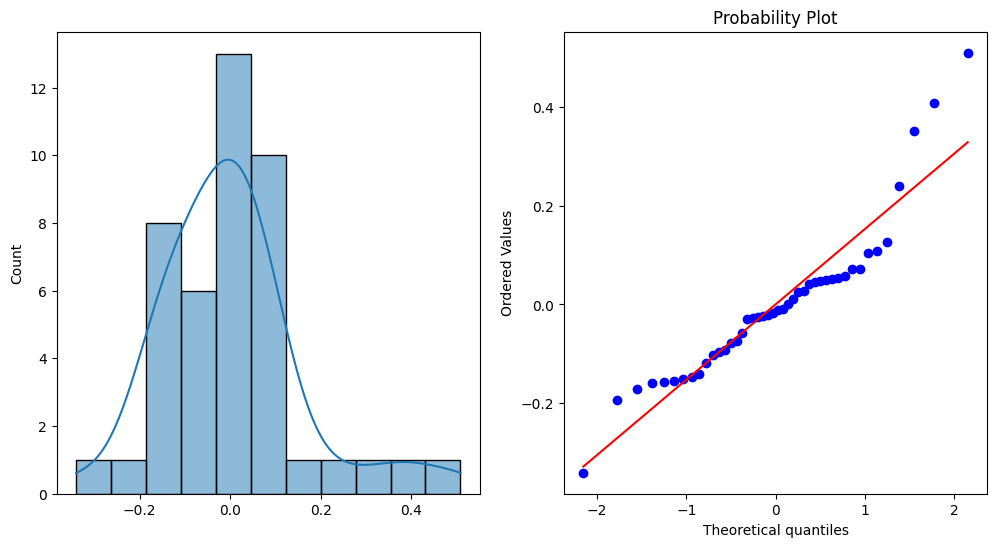

In [34]:
# Check assumptions for other models (lm_gold_on_others_new, lm_fixed_on_others_new, etc.)
check_assumptions(lm_gold_on_others_new, data)
check_assumptions(lm_fixed_on_others_new, data)
check_assumptions(lm_stock_on_others_new, data)
check_assumptions(lm_sixm_on_others_new, data)
check_assumptions(lm_fivey_on_others_new, data)
check_assumptions(lm_teny_on_others_new, data)

In [19]:
# Calculate the return rate - Asset/Inflation
data['House_proportion'] = data['House_Change'] / data['core_inflation']
data['Gold_proportion'] = data['Gold_Change'] / data['core_inflation']
data['Fixed_deposit_proportion'] = data['Fixed_deposit_rate'] / data['core_inflation']
data['Shanghai_stock_proportion'] = data['Shanghai_stock_Change'] / data['core_inflation']
data['Gover_sixm_proportion'] = data['government_bond_yield_sixm'] / data['core_inflation']
data['Gover_fivey_proportion'] = data['government_bond_yield_fivey'] / data['core_inflation']
data['Gover_teny_proportion'] = data['government_bond_yield_teny'] / data['core_inflation']

# Plot change percentage using plotly express
fig = px.line(data, x='Time', y=['House_proportion', 'Gold_proportion', 'Fixed_deposit_proportion',
                                  'Shanghai_stock_proportion', 'Gover_sixm_proportion', 'Gover_fivey_proportion',
                                  'Gover_teny_proportion'],
              line_shape='linear', labels={'value': 'Return Rate'}, title='Multiple Lines for Each Asset vs. Inflation Over Time')

# Show the plot
fig.show()

/Users/yujuechen/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

